In [10]:
# show file path of jupyter notebook
import os

/Users/pablo/software/ngpt-mlip/cbp/__file__


In [58]:
import torch
from model import CBPSimpleMLP
from torch_geometric.datasets import QM9
import numpy as np

# model = CBPSimpleMLP(num_features=3696, num_hidden=1000, num_targets=1)

In [21]:
# load data
if not os.path.exists('../data/QM9'):
    force_reload = True
else:
    force_reload = False

dataset = QM9(root='../data', force_reload=force_reload)

/Users/pablo/software/ngpt-mlip/.venv/lib/python3.11/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [32]:
from dscribe.descriptors import SOAP
from ase.atoms import Atoms
soap_desc = SOAP(species=["C", "H", "O", "N", "F"], r_cut=5, n_max=8, l_max=6, average="inner")
dummy = Atoms("H2O")
dummy_desc = soap_desc.create(dummy)
print(dummy_desc.shape[0])

5740


In [92]:
model = CBPSimpleMLP(num_features=dummy_desc.shape[0], num_hidden=1000, num_targets=1)

In [93]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4500, gamma=0.5)
criterion = torch.nn.MSELoss()

In [94]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

train_data, val_data, test_data = random_split(dataset, [0.85, 0.05, 0.1])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [95]:
data = next(iter(train_loader))

In [96]:
data.ptr

tensor([  0,  19,  37,  50,  65,  88, 107, 122, 138, 156, 175, 197, 218, 236,
        256, 274, 291, 301, 320, 341, 359, 378, 399, 418, 434, 453, 474, 490,
        507, 528, 543, 564, 584])

In [97]:
data = next(iter(train_loader))
def train():
    model.train()
    optimizer.zero_grad()
    # Process each molecule in batch
    descs = []
    for i in range(len(data.ptr) - 1):
        # Extract single molecule from batch
        start, end = data.ptr[i], data.ptr[i+1]
        atoms = Atoms(
            numbers=data.z[start:end].tolist(),
            positions=data.pos[start:end].tolist()
        )
        desc = soap_desc.create(atoms)
        descs.append(torch.tensor(desc, dtype=torch.float32))
    descs = torch.vstack(descs)
    out = model(descs)
    target = data.y[:,7].unsqueeze(1)
    loss = criterion(out, target)
    # print(f"{out.shape=}, {target.shape=}")
    loss.backward()
    optimizer.step()
    return loss.item()

In [98]:
for epoch in range(1, 5000):
    loss = train()
    scheduler.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')


Epoch 50, Loss: 3792264.7500, LR: 0.001000
Epoch 100, Loss: 597863.3125, LR: 0.001000
Epoch 150, Loss: 226767.0938, LR: 0.001000
Epoch 200, Loss: 178743.3125, LR: 0.001000
Epoch 250, Loss: 158509.6562, LR: 0.001000
Epoch 300, Loss: 143813.0000, LR: 0.001000
Epoch 350, Loss: 131060.4219, LR: 0.001000
Epoch 400, Loss: 119309.2344, LR: 0.001000
Epoch 450, Loss: 108336.8516, LR: 0.001000
Epoch 500, Loss: 98091.9375, LR: 0.001000
Epoch 550, Loss: 88538.3281, LR: 0.001000
Epoch 600, Loss: 79662.3203, LR: 0.001000
Epoch 650, Loss: 71459.2031, LR: 0.001000
Epoch 700, Loss: 63927.6016, LR: 0.001000
Epoch 750, Loss: 57064.2344, LR: 0.001000
Epoch 800, Loss: 50859.4180, LR: 0.001000
Epoch 850, Loss: 45298.2812, LR: 0.001000
Epoch 900, Loss: 40353.7734, LR: 0.001000
Epoch 950, Loss: 35991.5625, LR: 0.001000
Epoch 1000, Loss: 32169.1270, LR: 0.001000
Epoch 1050, Loss: 28836.8301, LR: 0.001000
Epoch 1100, Loss: 25942.1250, LR: 0.001000
Epoch 1150, Loss: 23430.1133, LR: 0.001000
Epoch 1200, Loss: 212

In [101]:
with torch.no_grad():
    model.eval()
    descs = []
    for i in range(len(data.ptr) - 1):
        # Extract single molecule from batch
        start, end = data.ptr[i], data.ptr[i+1]
        atoms = Atoms(
            numbers=data.z[start:end].tolist(),
            positions=data.pos[start:end].tolist()
        )
        desc = soap_desc.create(atoms)
        descs.append(torch.tensor(desc, dtype=torch.float32))
    descs = torch.vstack(descs)
    out = model(descs)
    print(out)


tensor([[-12456.3379],
        [-10393.2490],
        [-12551.7695],
        [-11913.7178],
        [-11373.7139],
        [-10968.5967],
        [-10974.4053],
        [-12522.0615],
        [-11309.7324],
        [-12892.8379],
        [-11407.7510],
        [-10907.3799],
        [ -9496.6553],
        [-10911.6494],
        [-11404.0615],
        [-12926.3096],
        [-10937.4004],
        [-11779.8428],
        [-11813.1787],
        [ -9929.4297],
        [-11544.7393],
        [-10878.4326],
        [-10846.6885],
        [-10905.1035],
        [-10496.0547],
        [ -8551.9775],
        [-11945.9189],
        [-10532.5625],
        [-10339.4072],
        [-11915.6416],
        [ -9935.7480],
        [-12552.8555]])


In [102]:
data.y[:,7]

tensor([-12456.6152, -10394.7930, -12553.4160, -11913.6953, -11373.6348,
        -10968.2178, -10970.7734, -12520.1357, -11309.9805, -12893.6465,
        -11408.1865, -10906.9854,  -9497.0439, -10911.2334, -11406.7881,
        -12925.4111, -10937.5283, -11780.0244, -11812.0732,  -9928.6992,
        -11542.6934, -10878.3564, -10846.5186, -10904.0664, -10498.8330,
         -8551.8818, -11948.9355, -10533.0234, -10338.8525, -11914.9219,
         -9934.7188, -12553.4434])

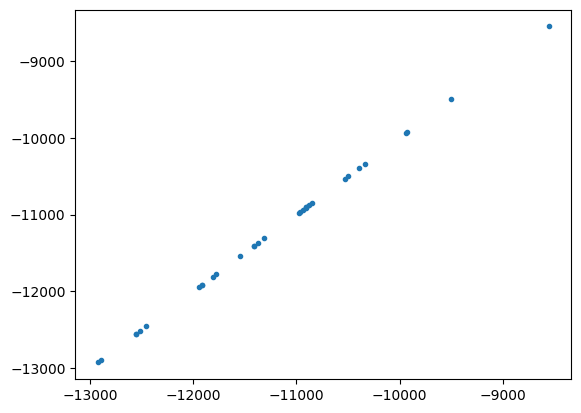

In [104]:
import matplotlib.pyplot as plt
plt.plot(data.y[:,7], out, '.')